In [1]:
import numpy as np
import numpy.ma as ma
from pygeotools.lib import malib, warplib, iolib, geolib
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
#importing rasters after warping them through GDAL Warp as masked arrays to common extent
fn1='B-tile-0_shpclip.tif' #DEM Clipped to glacier extent
fn2='WV-Carto.tif' #Elevation Difference Clipped to Glacier extent
ds_list=warplib.memwarp_multi_fn([fn1,fn2],res='max',extent='intersection',t_srs='first', r='bilinear')
E=iolib.ds_getma(ds_list[0])
dh_dt=iolib.ds_getma(ds_list[1])


Warping all inputs to the following:
Resolution: 10.0
Extent: [551565.0, 3029605.0, 704093.339, 3115655.0]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: bilinear

1 of 2: B-tile-0_shpclip.tif
nl: 8605 ns: 15253 res: 10.000
2 of 2: WV-Carto.tif
nl: 8605 ns: 15253 res: 10.000


### Defining common mask

In [3]:
common_mask=malib.common_mask([E,dh_dt])
E_masked=ma.array(E,mask=common_mask)
dh_dt_masked=ma.array(dh_dt,mask=common_mask)

### Getting 50 m elevation bands

In [4]:
 #Define min and max elevation
bin_width= 50
minx, maxx= list(malib.calcperc(E_masked, perc=(0.01, 99.99)))
minx = np.floor(minx/bin_width) * bin_width
maxx = np.ceil(maxx/bin_width) * bin_width
#Compute bin edges and centers
xedges = np.arange(minx, maxx + bin_width, bin_width)
xcenters = xedges[:-1] + np.diff(xedges)/2.0

In [5]:
maxx

7950.0

### Copying dh/dt into 2 numpy masked arrays

In [10]:
dz1=ma.copy(dh_dt_masked)
dz2=ma.copy(dh_dt_masked)

In [7]:
dz1

masked_array(data =
 [[-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 ..., 
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]],
             mask =
 [[ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 ..., 
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]],
       fill_value = 0.0)

### Calculation for each 50 elevation bands

In [12]:
for i in range (len(xedges)-1):
    idx= [(E_masked < xedges[i+1]) & (E_masked >= xedges[i])]
    print 'Unfiltered Stats'
    M=malib.print_stats(dh_dt_masked[idx])
    Count=M[0]
    Min=M[1]
    Max=M[2]
    Mean=M[3]
    Std=M[4]
    Med=M[5]
    IQR=M[9]
    Max_STD=Mean+3*Std
    Min_STD=Mean-3*Std
    Q1=M[7]
    Q3=M[8]
    U=Q3+1.5*IQR
    L=Q1-1.5*IQR
    r1={'Elevation':[xedges[i]],'Count':[Count], 'Mean':[Mean], 'Median':[Med], 'Standard_Deviation':[Std]}
    df1=pd.DataFrame(r1, columns=['Elevation','Count','Mean', 'Median', 'Standard_Deviation'])
    if i==0:
        df_unfilterd = df1
    else:
        df_unfilterd = df_unfilterd.append(df1)
    #dz1 is for mean +/-3 std
    dz1[idx]=ma.masked_outside(dz1[idx],Min_STD, Max_STD)
    #test=np.logical_and(dh_dt_masked[idx].__gt__(Min_STD), dh_dt_masked[idx].__lt__(Max_STD))
    #s=dz1[idx]*test
    #dz1[idx]=ma.masked_where(s == 0, s)
    print 'Stats after mean+/-3*std'
    K=malib.print_stats(dz1[idx])
    Count1=K[0]
    Min1=K[1]
    Max1=K[2]
    Mean1=K[3]
    Std1=K[4]
    Med1=K[5]
    r2={'Elevation':[xedges[i]],'Count':[Count1], 'Mean':[Mean1], 'Median':[Med1], 'Standard_Deviation':[Std1]}
    df2=pd.DataFrame(r2, columns=['Elevation','Count','Mean', 'Median', 'Standard_Deviation'])
    if i==0:
        df_mean_3std = df2
    else:
        df_mean_3std = df_mean_3std.append(df2)
    #malib.print_stats(dz1[idx])
    #dz1[(dh_dt_masked[idx]>=Min_STD) & (dh_dt_masked[idx]<=Max_STD)]=ma.masked
    #dz2 is for 1.5 fold IQR 
    dz2[idx]=ma.masked_outside(dz2[idx],L,U)
    print 'Stats after 1.5 IQR'
    L=malib.print_stats(dz2[idx])
    Count2=L[0]
    Min2=L[1]
    Max2=L[2]
    Mean2=L[3]
    Std2=L[4]
    Med2=L[5]
    r3={'Elevation':[xedges[i]],'Count':[Count2], 'Mean':[Mean2], 'Median':[Med2], 'Standard_Deviation':[Std2]}
    df3=pd.DataFrame(r3, columns=['Elevation','Count','Mean', 'Median', 'Standard_Deviation'])
    if i==0:
        df_1_5_iqr = df3
    else:
        df_1_5_iqr = df_1_5_iqr.append(df3)

Unfiltered Stats
count: 2481 min: -8.88 max: 13.76 mean: -0.85 std: 2.71 med: -0.54 mad: 2.33 q1: -2.62 q2: 0.61 iqr: 3.23 mode: 0.58 p16: -3.37 p84: 1.15 spread: 2.26
Stats after mean+/-3*std
count: 2447 min: -8.88 max: 6.41 mean: -1.01 std: 2.32 med: -0.58 mad: 2.29 q1: -2.66 q2: 0.55 iqr: 3.21 mode: 0.58 p16: -3.39 p84: 1.08 spread: 2.23
Stats after 1.5 IQR
count: 2427 min: -7.42 max: 5.45 mean: -0.98 std: 2.24 med: -0.57 mad: 2.27 q1: -2.61 q2: 0.55 iqr: 3.16 mode: 0.58 p16: -3.34 p84: 1.08 spread: 2.21
Unfiltered Stats
count: 2815 min: -11.35 max: 15.38 mean: -0.85 std: 2.97 med: -0.85 mad: 1.46 q1: -2.05 q2: -0.03 iqr: 2.01 mode: 0.18 p16: -2.66 p84: 0.34 spread: 1.50
Stats after mean+/-3*std
count: 2740 min: -9.74 max: 8.03 mean: -1.05 std: 2.28 med: -0.88 mad: 1.43 q1: -2.05 q2: -0.08 iqr: 1.98 mode: 0.18 p16: -2.64 p84: 0.28 spread: 1.46
Stats after 1.5 IQR
count: 2495 min: -5.03 max: 2.99 mean: -1.07 std: 1.35 med: -0.89 mad: 1.28 q1: -1.94 q2: -0.15 iqr: 1.80 mode: 0.18 p16:

Unfiltered Stats
count: 36043 min: -12.51 max: 14.24 mean: -0.66 std: 1.73 med: -0.68 mad: 1.17 q1: -1.51 q2: 0.06 iqr: 1.58 mode: -0.85 p16: -1.93 p84: 0.50 spread: 1.22
Stats after mean+/-3*std
count: 35432 min: -5.83 max: 4.52 mean: -0.74 std: 1.44 med: -0.69 mad: 1.14 q1: -1.52 q2: 0.03 iqr: 1.55 mode: -0.85 p16: -1.93 p84: 0.44 spread: 1.19
Stats after 1.5 IQR
count: 33660 min: -3.88 max: 2.43 mean: -0.73 std: 1.17 med: -0.69 mad: 1.07 q1: -1.46 q2: -0.01 iqr: 1.45 mode: -0.85 p16: -1.83 p84: 0.36 spread: 1.09
Unfiltered Stats
count: 64000 min: -16.05 max: 13.78 mean: -0.63 std: 1.59 med: -0.52 mad: 1.05 q1: -1.31 q2: 0.12 iqr: 1.44 mode: -2.22 p16: -1.83 p84: 0.48 spread: 1.16
Stats after mean+/-3*std
count: 63080 min: -5.40 max: 4.13 mean: -0.61 std: 1.33 med: -0.52 mad: 1.03 q1: -1.30 q2: 0.11 iqr: 1.41 mode: -2.22 p16: -1.79 p84: 0.46 spread: 1.13
Stats after 1.5 IQR
count: 59751 min: -3.47 max: 2.27 mean: -0.57 std: 1.08 med: -0.50 mad: 0.96 q1: -1.21 q2: 0.09 iqr: 1.31 mode:

count: 329622 min: -2.89 max: 1.59 mean: -0.62 std: 0.80 med: -0.57 mad: 0.73 q1: -1.10 q2: -0.11 iqr: 0.99 mode: -0.23 p16: -1.39 p84: 0.10 spread: 0.75
Unfiltered Stats
count: 364956 min: -18.39 max: 16.95 mean: -0.64 std: 1.49 med: -0.51 mad: 0.77 q1: -1.10 q2: -0.04 iqr: 1.05 mode: 0.03 p16: -1.46 p84: 0.21 spread: 0.83
Stats after mean+/-3*std
count: 357463 min: -5.12 max: 3.84 mean: -0.59 std: 1.06 med: -0.51 mad: 0.75 q1: -1.07 q2: -0.05 iqr: 1.02 mode: 0.03 p16: -1.41 p84: 0.19 spread: 0.80
Stats after 1.5 IQR
count: 333859 min: -2.67 max: 1.53 mean: -0.54 std: 0.76 med: -0.49 mad: 0.68 q1: -1.00 q2: -0.06 iqr: 0.93 mode: 0.03 p16: -1.27 p84: 0.15 spread: 0.71
Unfiltered Stats
count: 397890 min: -18.49 max: 18.39 mean: -0.56 std: 1.54 med: -0.46 mad: 0.75 q1: -1.03 q2: -0.01 iqr: 1.02 mode: 0.15 p16: -1.38 p84: 0.24 spread: 0.81
Stats after mean+/-3*std
count: 389118 min: -5.17 max: 4.06 mean: -0.53 std: 1.05 med: -0.46 mad: 0.73 q1: -1.01 q2: -0.02 iqr: 0.99 mode: 0.15 p16: -1

Stats after 1.5 IQR
count: 99864 min: -1.91 max: 1.91 mean: 0.04 std: 0.68 med: 0.06 mad: 0.56 q1: -0.33 q2: 0.43 iqr: 0.76 mode: 0.24 p16: -0.57 p84: 0.64 spread: 0.60
Unfiltered Stats
count: 108767 min: -18.48 max: 18.39 mean: -0.02 std: 1.84 med: 0.09 mad: 0.66 q1: -0.38 q2: 0.51 iqr: 0.90 mode: 0.34 p16: -0.81 p84: 0.81 spread: 0.81
Stats after mean+/-3*std
count: 105997 min: -5.54 max: 5.50 mean: 0.01 std: 1.24 med: 0.09 mad: 0.64 q1: -0.36 q2: 0.50 iqr: 0.86 mode: 0.34 p16: -0.73 p84: 0.78 spread: 0.76
Stats after 1.5 IQR
count: 93470 min: -1.73 max: 1.86 mean: 0.09 std: 0.65 med: 0.11 mad: 0.54 q1: -0.26 q2: 0.46 iqr: 0.72 mode: 0.34 p16: -0.48 p84: 0.68 spread: 0.58
Unfiltered Stats
count: 97438 min: -18.32 max: 15.82 mean: -0.09 std: 1.87 med: 0.09 mad: 0.65 q1: -0.42 q2: 0.49 iqr: 0.90 mode: 0.38 p16: -0.88 p84: 0.76 spread: 0.82
Stats after mean+/-3*std
count: 95054 min: -5.68 max: 5.50 mean: -0.02 std: 1.25 med: 0.10 mad: 0.63 q1: -0.39 q2: 0.48 iqr: 0.86 mode: 0.38 p16: -0

Unfiltered Stats
count: 14418 min: -17.69 max: 18.25 mean: 0.32 std: 1.88 med: 0.35 mad: 0.48 q1: -0.03 q2: 0.63 iqr: 0.66 mode: 1.52 p16: -0.34 p84: 0.81 spread: 0.58
Stats after mean+/-3*std
count: 14064 min: -5.30 max: 5.89 mean: 0.26 std: 1.12 med: 0.34 mad: 0.46 q1: -0.03 q2: 0.62 iqr: 0.64 mode: 1.52 p16: -0.32 p84: 0.78 spread: 0.55
Stats after 1.5 IQR
count: 12235 min: -1.03 max: 1.62 mean: 0.31 std: 0.47 med: 0.35 mad: 0.38 q1: 0.06 q2: 0.59 iqr: 0.53 mode: 1.52 p16: -0.12 p84: 0.70 spread: 0.41
Unfiltered Stats
count: 12806 min: -14.92 max: 16.17 mean: 0.33 std: 1.56 med: 0.37 mad: 0.53 q1: -0.02 q2: 0.70 iqr: 0.72 mode: 0.48 p16: -0.32 p84: 0.93 spread: 0.62
Stats after mean+/-3*std
count: 12508 min: -4.34 max: 4.99 mean: 0.33 std: 1.02 med: 0.37 mad: 0.51 q1: -0.01 q2: 0.68 iqr: 0.69 mode: 0.48 p16: -0.30 p84: 0.90 spread: 0.60
Stats after 1.5 IQR
count: 10973 min: -1.10 max: 1.78 mean: 0.34 std: 0.51 med: 0.37 mad: 0.43 q1: 0.06 q2: 0.64 iqr: 0.58 mode: 0.48 p16: -0.14 p84

### Defining the upper and lower bound for the error shading in the plots..

In [23]:
df_1_5_iqr['E_negative']=df_1_5_iqr['Median']-df_1_5_iqr['Standard_Deviation']
df_1_5_iqr['E_positive']=df_1_5_iqr['Median']+df_1_5_iqr['Standard_Deviation']
df_1_5_iqr.set_index('Elevation')
df_1_5_iqr

,Elevation,Count,Mean,Median,Standard_Deviation,E_negative,E_positive
0,3950.0,2427,-0.978926,-0.572748,2.243585,-2.816333,1.670837
0,4000.0,2495,-1.069952,-0.885031,1.350816,-2.235847,0.465785
0,4050.0,1377,-1.073360,-0.929138,1.157767,-2.086905,0.228630
0,4100.0,1001,-1.017654,-1.093038,1.087524,-2.180562,-0.005514
0,4150.0,2099,-0.863326,-0.700092,1.037277,-1.737369,0.337185
0,4200.0,4407,-0.561518,-0.639197,0.856116,-1.495313,0.216919
0,4250.0,5454,-0.574369,-0.590496,0.699336,-1.289832,0.108841
0,4300.0,6801,-0.588600,-0.558298,0.766010,-1.324308,0.207712
0,4350.0,15495,-0.611708,-0.599740,0.720005,-1.319745,0.120265
0,4400.0,16068,-0.610454,-0.618339,0.697797,-1.316136,0.079457


### Ploting the Curve

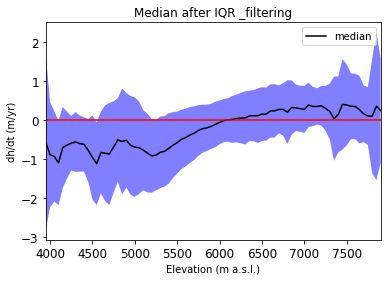

In [32]:
ax1=df_1_5_iqr.plot(x='Elevation',y='Median',color='black', label='median',title='Median after IQR _filtering')
#f_1_5_iqr.plot(df_1_5_iqr.index,y=df_1_5_iqr['Median'],color='black', label='median')
ax1.fill_between(df_1_5_iqr['Elevation'], df_1_5_iqr['E_negative'], df_1_5_iqr['E_positive'],alpha=0.5, facecolor='#0000FF')
ax1.set_ylabel('dh/dt (m/yr)' )
ax1.tick_params('y', colors='k', labelsize='large')
ax1.set_xlabel('Elevation (m a.s.l.)')
ax1.tick_params('x', colors='k', labelsize='large')
# TITLE
#x1.title('Median after IQR _filtering',fontsize=30, y=1.05)
#x1.tight_layout()
plt.axhline(y=0,hold=None,color='r')
plt.show()

### Writing out the filtered files

In [36]:
out_fn = 'Filtered_dh_mean+_3std.tif' 
iolib.writeGTiff(dz1, out_fn, ds_list[1])
out_f1n = 'Filtered_dh_1_5_IQR.tif' 
iolib.writeGTiff(dz2, out_f1n, ds_list[1])

### Stats for the orignal and filtered dh/dt data

In [33]:
malib.print_stats(dz1)

count: 8703972 min: -12.64 max: 17.85 mean: -0.44 std: 1.22 med: -0.33 mad: 0.84 q1: -0.99 q2: 0.17 iqr: 1.16 mode: 0.30 p16: -1.40 p84: 0.44 spread: 0.92


(8703972,
 -12.64471,
 17.848867,
 -0.44402574938163786,
 1.2207054231834178,
 -0.33439087867736816,
 0.83969222409725186,
 -0.98748926818370819,
 0.16846141591668129,
 1.1559506841003895,
 0.3039511442184448,
 -1.3950952053070069,
 0.43938440680503837,
 0.91723980605602262)

In [34]:
malib.print_stats(dz2)

count: 8019940 min: -7.42 max: 17.85 mean: -0.41 std: 0.87 med: -0.32 mad: 0.75 q1: -0.90 q2: 0.14 iqr: 1.03 mode: 0.54 p16: -1.23 p84: 0.36 spread: 0.80


(8019940,
 -7.4223533,
 17.848867,
 -0.41039152989062011,
 0.87142698757568737,
 -0.32304193079471588,
 0.75376673188805576,
 -0.89870761334896088,
 0.13524698466062546,
 1.0339545980095863,
 0.5423442125320435,
 -1.2261130762100221,
 0.36411523818969727,
 0.79511415719985967)

In [35]:
malib.print_stats(dh_dt_masked)

count: 8906420 min: -18.49 max: 18.49 mean: -0.49 std: 1.72 med: -0.34 mad: 0.87 q1: -1.02 q2: 0.18 iqr: 1.20 mode: -0.01 p16: -1.46 p84: 0.46 spread: 0.96


(8906420,
 -18.493341,
 18.490902,
 -0.48513167595254841,
 1.7178013031701282,
 -0.33951742947101593,
 0.8667913676977157,
 -1.0191538333892822,
 0.17624152824282646,
 1.1953953616321087,
 -0.007494932971894741,
 -1.4577193260192871,
 0.46018848896026621,
 0.9589539074897766)